# Noise detection


1. Agglomeratives Clustering
    - *Triebe* abschneiden
    - *Triebe* = Gedichte, die nach wenigen Aufteilungen eigene Cluster bilden
2. Topic Modelling
    - auffällige Topics finden
    - John Brinckman &rarr; niederdeutsche Sprache
    - Fritz Reuter &rarr; niederdeutsche" Sprache
3. LSVM
    - mithilfe von Fehlklassifizierungen & Konfusionsmatrizen "fehlerhafte" Dichter finden
    - nicht erfolgreich, Clustering wurde durch Entfernung schlechter

In [16]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from nltk import word_tokenize
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage, ward
from stop_words import get_stop_words
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

from utils import add_epoch_division, alter_epoch_division, linkage_matrix, plot_dendrogram, remove_noise_poet, text_cleaning

In [24]:
corpus = pd.read_csv("../corpora/amann_poems_noiseless.csv")

In [25]:
corpus.shape

(206, 6)

### loading corpus

In [168]:
DIM_RED = False
DOWNSAMPLED = False
LOAD_LINKAGE = False
LOWERCASE = True
MAX_FEATURES = 10000
PATH = "../corpora/amann_poems.csv"
CORPUS_NAME = "amann"
REDUCE_CORPUS = False
STOP_WORDS = get_stop_words("de")

In [48]:
corpus = text_cleaning(pd.read_csv(PATH))

In [49]:
corpus = corpus[corpus.epoch != "Sturm_Drang"]

#### downsampling & corpus reducing

In [50]:
def random_downsampling(corpus, class_col = "epoch", max_value = 14):
    """ Reduces all instances of all classes to a certain maximum value.
    """   
    
    unique_epochs = list(np.unique(corpus[class_col]))
    subcorpora = []
    
    for epoch in unique_epochs:
        subcorpus = corpus[corpus[class_col] == epoch]
        subcorpus = subcorpus.sample(max_value)
        subcorpora.append(subcorpus)
    
    return pd.concat(subcorpora, axis=0)

if DOWNSAMPLED:
    corpus = random_downsampling(corpus)

In [51]:
# reduce corpus
if REDUCE_CORPUS:
    epoch1 = "Frühaufklärung"
    epoch2 = "Realismus"
    corpus = corpus[(corpus.epoch == epoch1) | (corpus.epoch == epoch2)]

### vectorizing text

In [52]:
vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(corpus["poem"])

In [53]:
text = corpus["poem"]
shortened_classes = [c[:2] for c in corpus["epoch"].values]
ids = [p for p in corpus["id"].values]

# 1. Agglomerative Clustering

In [54]:
if LOAD_LINKAGE:
    preload_linkage = pd.read_csv("../results/hierarchical_clusters/linkage_matrix_poems.csv")
    preload_linkage = preload_linkage.to_numpy()

In [55]:
if DIM_RED:
    pca = PCA(n_components=3)
    X_red = pca.fit_transform(vector.toarray())
else:
    X_red = vector.toarray()

In [56]:
%%time
agcl = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model = agcl.fit(X_red)

CPU times: user 449 ms, sys: 7.74 ms, total: 457 ms
Wall time: 460 ms


### results

In [57]:
def get_font_size(p):
    """ Adjusts the font size.
    """
    font_size = 8-p
    if font_size < 4:
        font_size = 4
    return font_size    

In [58]:
if LOAD_LINKAGE:
    link_matrix = preload_linkage
    cluster_labels = list(pd.read_csv("../corpora/german_poems.csv").pid.unique())
else:
    link_matrix = linkage_matrix(model) 
    cluster_labels = ids

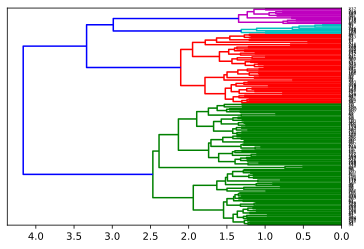

In [59]:
p = 8

l = dendrogram(link_matrix, 
               p=p, 
               truncate_mode='level', 
               labels=cluster_labels, 
               orientation="left",
               leaf_font_size=get_font_size(p),
               no_plot=False,
               show_leaf_counts=True,
               show_contracted=False,
               get_leaves=True)
plt.show()

### different p's in order to find noise

In [61]:
SAVE_FIG = False
MAX_RANGE = 20

for i in range(1,MAX_RANGE):

    p = i

    l = dendrogram(link_matrix, 
                   p=p, 
                   truncate_mode='level', 
                   labels=cluster_labels, 
                   orientation="left",
                   leaf_font_size=get_font_size(p),
                   no_plot=False,
                   show_leaf_counts=False,
                   show_contracted=False,
                   get_leaves=True)
    if p < 10 and SAVE_FIG:
        plt.title(f"Truncate (p): {p}")
        plt.savefig(f"../results/hierarchical_clusters/p_img/{p}.png", dpi=200)
    plt.clf()
    
    
    print(f"{p} \t {len(l['ivl'])}")

1 	 4
2 	 8
3 	 16
4 	 31
5 	 55
6 	 90
7 	 135
8 	 178
9 	 199
10 	 217
11 	 226
12 	 235
13 	 239
14 	 240
15 	 240
16 	 240
17 	 240
18 	 240
19 	 240


<Figure size 432x288 with 0 Axes>

In [162]:
p = 10

l = dendrogram(link_matrix, 
               p=p, 
               truncate_mode='level', 
               labels=cluster_labels, 
               orientation="left",
               leaf_font_size=get_font_size(p),
               no_plot=True,
               show_leaf_counts=False,
               show_contracted=False,
               get_leaves=True)

print(f"{p} \t {len(l['ivl'])}")

10 	 217


### Remove noise with agglomerative clustering

In [163]:
if LOAD_LINKAGE:
    corpus = pd.read_csv("../corpora/german_poems.csv")
    id_name = "pid"
else:
    id_name = "id"

not_noise = [leaf for leaf in l["ivl"] if leaf != ""]
noise = [leaf for leaf in cluster_labels if leaf not in not_noise]

noise_df = corpus[corpus[id_name].isin(noise)]
noiseless_df = corpus[corpus[id_name].isin(not_noise)]

In [164]:
noiseless_df.shape

(208, 6)

In [166]:
noiseless_df.epoch.value_counts()

Aufklärung         53
Barock             37
Realismus          28
Biedermeier        24
Romantik           20
Klassik            17
Naturalismus       16
Expressionismus    13
Name: epoch, dtype: int64

In [161]:
"""TODO
noiseless_df = noiseless_df[noiseless_df.epoch != "Romantik"]
noiseless_df = noiseless_df[noiseless_df.epoch != "Naturalismus"]
noiseless_df.to_csv("../corpora/test.csv", index=False)
"""

'\nnoiseless_df = noiseless_df[noiseless_df.epoch != "Romantik"]\nnoiseless_df = noiseless_df[noiseless_df.epoch != "Naturalismus"]\nnoiseless_df.to_csv("../corpora/test.csv", index=False)\n'

In [128]:
noise_df.epoch.value_counts()

Klassik            10
Romantik            8
Realismus           5
Biedermeier         3
Naturalismus        2
Aufklärung          2
Barock              1
Expressionismus     1
Name: epoch, dtype: int64

In [129]:
if LOAD_LINKAGE:
    output_path = "../corpora/german_poems_noiseless.csv"
else:
    output_path = "../corpora/amann_poems_noiseless.csv"
    
noiseless_df.to_csv(output_path, index=False)
#noise_df.to_csv(output_path, index=False)

## 2. Topic Modelling

In [131]:
corpus.head(1)

,id,poet,poem,year,epoch,poemlength
0,0,"Abschatz, Hans Aßmann von",Du angenehmer Häyn voll stiller Einsamkeiten/ ...,1679,Barock,62284


#### corpus to text

In [40]:
"""
for idx, row in corpus.iterrows():
    name = row.poet + "_" + row.epoch
    with open(f"../corpora/malletfiles/corpustext/{name}.txt", "w") as f:
        f.write(row.poem)
"""

'\nfor idx, row in corpus.iterrows():\n    name = row.poet + "_" + row.epoch\n    with open(f"../corpora/malletfiles/corpustext/{name}.txt", "w") as f:\n        f.write(row.poem)\n'

#### epochs to txt

In [37]:
"""
for epoch in list(corpus.epoch.unique()):
    df = corpus[corpus.epoch == epoch]
    Path(f"../corpora/epochtexts/{epoch}").mkdir(parents=True, exist_ok=True)
    for idx, row in df.iterrows():
        name = row.poet + "_" + row.epoch
        with open(f"../corpora/malletfiles/epochtexts/{epoch}/{name}.txt", "w") as f:
            f.write(row.poem)
"""

'\nfor epoch in list(corpus.epoch.unique()):\n    df = corpus[corpus.epoch == epoch]\n    Path(f"../corpora/epochtexts/{epoch}").mkdir(parents=True, exist_ok=True)\n    for idx, row in df.iterrows():\n        name = row.poet + "_" + row.epoch\n        with open(f"../corpora/epochtexts/{epoch}/{name}.txt", "w") as f:\n            f.write(row.poem)\n'

#### filter poets by topic

In [132]:
topic = "dat nich hei ick denn wat sin noch man sick tau seggt dor nit isch all herr mal sei min" 
topic = [w for w in topic.split(" ")]

In [133]:
topic_poets = {}
for idx, row in corpus.iterrows():
    text = word_tokenize(row.poem)
    topic_appearance = [w for w in topic if w in text]
    name = row.poet + "_" + row.epoch
    topic_poets[name] = len(topic_appearance)

In [134]:
min_count = 15
sorted_topic_poets = {k: v for k, v in sorted(topic_poets.items(), 
                                               key=lambda item: item[1], 
                                               reverse=True) if v >= min_count}

In [135]:
noise_poets = [p.split("_")[0] for p in list(sorted_topic_poets.keys())]
corpus[corpus.poet.isin(noise_poets)]

,id,poet,poem,year,epoch,poemlength
19,20,"Brinckman, John","Dat wohrt so lang nu, as dat wohrt, ick, Vader...",1842,Realismus,31033
184,228,"Reuter, Fritz","Is in dat Dörp 'ne Kindelbier, Denn hungert un...",1842,Biedermeier,99868


In [137]:
noiseless_df2 = noiseless_df[~noiseless_df.poet.isin(noise_poets)]

In [138]:
noiseless_df2.shape

(206, 6)

In [140]:
#noiseless_df2.to_csv("../corpora/amann_poems_noiseless.csv", index=False)

## 3. LSVM

In [2]:
corpus = text_cleaning(pd.read_csv("../results/lsvm/lsvm_preds_amann.csv"))
conf_matrix = pd.read_csv("../results/lsvm/lsvm_cm_amann.csv", index_col=0)
time_order = ["Barock", "Aufklärung", "Klassik", "Romantik", "Biedermeier",
              "Realismus", "Naturalismus", "Expressionismus"]
conf_matrix = conf_matrix[time_order]
conf_matrix = conf_matrix.loc[time_order, :]

In [3]:
conf_matrix_normalized = conf_matrix / conf_matrix.astype(np.float).sum(axis=1)
conf_matrix_normalized = np.around(conf_matrix_normalized, decimals=3)*100

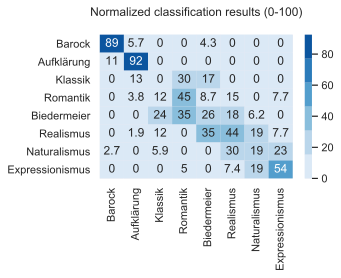

In [4]:
SAVEFIG = False
if SAVEFIG:
    plt.figure(figsize=(10,8))
else:
    plt.figure(figsize=(5,4))
sns.set(font_scale=1.0)
sns.heatmap(conf_matrix_normalized, annot=True, cmap=sns.color_palette("Blues"))
plt.title("Normalized classification results (0-100)\n")
plt.tight_layout()
if SAVEFIG:
    plt.savefig("../results/lsvm/confusionmatrix.png", dpi=300)
plt.show()

In [5]:
noise_corpus = corpus[corpus.epoch != corpus.pred]

In [6]:
poet_counts = dict(corpus.poet.value_counts())
noise_poets = dict(noise_corpus.poet.value_counts())

In [7]:
problematic_poets = []

for k, v in noise_poets.items():
    if k in poet_counts:
         if v == poet_counts[k] and v > 1:
            problematic_poets.append(k)

In [8]:
noiseless_corpus = corpus[~corpus.poet.isin(problematic_poets)]
del noiseless_corpus["pred"]

In [13]:
noisy = corpus[corpus.poet.isin(problematic_poets)]

In [15]:
noisy.shape

(32, 7)

In [297]:
#noiseless_corpus.to_csv("../corpora/amann_poems_noiseless.csv")